In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import sys
from numba import cuda
import math

In [17]:
# def stepCopy(strategies,record,t):
#     #trade
#     benefits = getBenefits(strategies,b)
#     #update records
#     record[:,:,t,0] = strategies
#     record[:,:,t,1] = benefits
#     # #update strategy 
#     alternativeStrategies,alternativeBenefits = getAlternativesCopy(strategies,benefits)
#     updatingResults = getUpdatingResults(getUpdatingFactors(beta,benefits,alternativeBenefits))
#     new_strategies = updateStrategy(strategies,alternativeStrategies,updatingResults)
#     return new_strategies,record   

In [18]:
# tradeAdjacency = np.zeros((l,l,l,l),dtype=np.float64)
# recordAdjacency = np.zeros((l,l,l,l),dtype=np.float64)
# wealth = np.zeros((l,l))


# wealth = np.ones((l,l))


# for i in range(l):
#     for j in range(l):
#         tradeAdjacency[i,j,(i+1)%l,j] = 1
#         tradeAdjacency[i,j,i-1,j] = 1
#         tradeAdjacency[i,j,i,(j+1)%l] = 1
#         tradeAdjacency[i,j,i,j-1] = 1
#         tradeAdjacency[i,j,i,j] = 1
#         
#         recordAdjacency[i,j,(i+1)%l,j] = 1
#         recordAdjacency[i,j,i-1,j] = 1
#         recordAdjacency[i,j,i,(j+1)%l] = 1
#         recordAdjacency[i,j,i,j-1] = 1
#         recordAdjacency[i,j,i,j] = 1

In [3]:
@njit
def applyK(input,kernel):
    l = input.shape[0]
    output = np.zeros(input.shape)
    for x in range(input.shape[0]):
        for y in range(input.shape[1]):
            for i in range(3):
                for j in range(3):
                    output[x,y] += input[(x-1 + i)%l,(y-1 + j )%l] * kernel[i,j]
                    
    return output
        

In [4]:
# @cuda.jit
# def applyKernel(input,output,kernel):
#     x,y = cuda.grid(2)
#     if x<input.shape[0] and y<input.shape[1]:       
#         for i in range(3):
#             for j in range(3):
#                 output[x,y] += input[(x-1 + i)%input.shape[0],(y-1 + j )%input.shape[1]] * kernel[i,j]

In [5]:
@njit
def getBenefits(strategies,magnificationFactor):
    
    kernel = np.array([[0,1,0],[1,1,1],[0,1,0]],dtype=np.float64)

    
    groupValues = applyK(strategies/5,kernel)
    benefits = applyK(groupValues*magnificationFactor/5,kernel)
    
    
#1     
    return benefits-strategies+1

In [6]:
@njit
def getUpdatingFactors(beta,benefits,alternativeBenefits):
    return 1/(1+np.exp(beta*(benefits-alternativeBenefits)))   # not only the present benefit but the memory of the present strat
    

@njit
def getUpdatingResults(updatingFactors):
    return np.random.uniform(0,1,size=(l,l))< updatingFactors

In [7]:
@njit
def updateStrategy(strategies,alternativeStrategies,updatingResults):
    return (1-updatingResults)*strategies + updatingResults*alternativeStrategies  #np.where

In [8]:
@njit
def getIndexMatrix(l): 
    indexLattice = np.zeros((l,l,2),dtype=np.int64)
    for i in range(l):
        for j in range(l):
            indexLattice[i,j] = i,j
            
    return indexLattice

In [25]:


@njit
def updateMemory(strategies,benefits,memory,m):
    meanMemory = np.zeros((memory.shape[0],memory.shape[1],2))   
    for i in range(memory.shape[2]):
        meanMemory += memory[:,:,i,:]
    meanMemory /= memory.shape[2]
    
    kernel = np.array([[0,1,0],[1,1,1],[0,1,0]],dtype=np.float64)
    n1 =  applyK(strategies,kernel)
    n0 = applyK((1-strategies),kernel)
    
    events1 = applyK(strategies*benefits,kernel) /n1
    events0 = applyK((1-strategies)*benefits,kernel) /n0
    
    events0 = np.where(n0==0,meanMemory[:,:,0],events0)
    events1 = np.where(n1==0,meanMemory[:,:,1],events1)



    events = np.concatenate((events0.reshape((l,l,1,1)),events1.reshape((l,l,1,1))),axis=3)
    memory = np.concatenate((memory,events),axis=2)




    return memory[:,:,-m:,:]



def getAlternativesLogic(strategies,memory):
    meanMemory = np.zeros((memory.shape[0],memory.shape[1],2))   
    for i in range(memory.shape[2]):
        meanMemory += memory[:,:,i,:]
    meanMemory /= memory.shape[2]
        
        
        
    neighborIndexes = np.zeros((l,l,2),dtype=np.int64)
    
    randomNeighbors = np.random.choice([0+1J,1,-1,0-1J],(l,l))
    neighborIndexes[:,:,0] = (indexMatrix[:,:,0] + randomNeighbors.real)%l
    neighborIndexes[:,:,1] = (indexMatrix[:,:,1] + randomNeighbors.imag)%l
     
    alternativeStrategies = np.array(strategies[neighborIndexes[:,:,0],neighborIndexes[:,:,1]],dtype=np.int64)
    
    #print(neighborIndexes.shape,alternativeStrategies.shape)
    alternativeBenefits = meanMemory[neighborIndexes[:,:,0],neighborIndexes[:,:,1],alternativeStrategies]
    
    
    meanBenefits = meanMemory[indexMatrix[:,:,0],indexMatrix[:,:,1],np.array(strategies,dtype=np.int64)]

    #alternativeBenefits = meanMemory[:,:,1]*alternativeStrategies  + meanMemory[:,:,0]*(1-alternativeStrategies)
    
    return meanBenefits,alternativeStrategies,alternativeBenefits

In [22]:
def stepCopy(strategies,record,t):
    #trade
    benefits = getBenefits(strategies,b)
    #update memory
    
    record[:,:,t,0] = strategies
    record[:,:,t,1] = benefits

    #update strategy 
        
    alternativeStrategies,alternativeBenefits = getAlternativesCopy(strategies,benefits)
    updatingResults = getUpdatingResults(getUpdatingFactors(beta,benefits,alternativeBenefits))
    new_strategies = updateStrategy(strategies,alternativeStrategies,updatingResults)
    
    return new_strategies,record

def getAlternativesCopy(strategies,benefits):

    neighborIndexes = np.zeros((l,l,2),dtype=np.int64)

    randomNeighbors = np.random.choice([0+1J,1,-1,0-1J],(l,l))
    neighborIndexes[:,:,0] = (indexMatrix[:,:,0] + randomNeighbors.real)%l
    neighborIndexes[:,:,1] = (indexMatrix[:,:,1] + randomNeighbors.imag)%l

    return strategies[neighborIndexes[:,:,0],neighborIndexes[:,:,1]] , benefits[neighborIndexes[:,:,0],neighborIndexes[:,:,1]]

In [23]:
def stepLogic(strategies,record,memory,m,t):
    #trade
    benefits = getBenefits(strategies,b)
    #update memory
    
    record[:,:,t,0] = strategies
    record[:,:,t,1] = benefits

    #update strategy 
    
    memory = updateMemory(strategies,benefits,memory,m)
    
    meanBenefits,alternativeStrategies,alternativeBenefits = getAlternativesLogic(strategies,memory)
    
    updatingResults = getUpdatingResults(getUpdatingFactors(beta,meanBenefits,alternativeBenefits))
    new_strategies = updateStrategy(strategies,alternativeStrategies,updatingResults)
    
    return new_strategies,record,memory

In [24]:
def getResults(p0,b,m,beta):
    l = 32
    N = l**2
    generationsNum = 500
    strategies = np.zeros((l,l))
    strategies = np.ones((l,l))*(np.random.uniform(0,1,size=(l,l))<p0)

    memory = np.ones((l,l,1,2),dtype=np.float64) 
    record = np.zeros((l,l,generationsNum,2),dtype=np.float64)
    indexMatrix = getIndexMatrix(l)
    iterations = 100
    datas = np.zeros((iterations,generationsNum))

    for i in range(iterations):
        strategies = np.ones((l,l))*(np.random.random(size=(l,l))<p0)
        memory = np.zeros((l,l,1,2),dtype=np.float64) 
        record = np.zeros((l,l,generationsNum,2),dtype=np.float64)
        for t in range(1,generationsNum):

        
            strategies,record,memory = stepLogic(strategies,record,memory,m,t)
        
        data = np.sum(record[:,:,:,0],axis=(0,1))/(l*l)
        datas[i,:] = data
    

    mean = np.mean(datas,axis=0)      


    plt.figure(figsize=(20,10))
    plt.title('b = '+str(b)+', p0 = '+str(p0)+', beta = '+str(beta)+', m = '+str(m)+ ", l = "+str(l))
    plt.xlabel('generations')
    plt.ylabel('mean cooperation')
    plt.xlim((0,generationsNum))
    plt.ylim((0,1))
    for i in range(iterations):
        plt.plot(np.arange(generationsNum),datas[i,:])
    



    plt.plot(np.arange(generationsNum),mean,lw= 10)
    plt.savefig("resultForB={0}.png".format(b))
    

In [25]:
l = 32
indexMatrix = getIndexMatrix(l)

In [31]:
def getResults2(p0,b,beta):
    l = 32
    generationsNum = 500
    iterations = 100
    datas = np.zeros((iterations,generationsNum))

    for i in range(iterations):
        strategies = np.ones((l,l))*(np.random.random(size=(l,l))<p0)
        record = np.zeros((l,l,generationsNum,2),dtype=np.float64)
        for t in range(1,generationsNum):

        
            strategies,record= stepCopy(strategies,record,t)
        
        data = np.sum(record[:,:,:,0],axis=(0,1))/(l*l)
        datas[i,:] = data
    

    mean = np.mean(datas,axis=0)      


    plt.figure(figsize=(20,10))
    plt.title('b = '+str(b)+', p0 = '+str(p0)+', beta = '+str(beta)+ ", l = "+str(l))
    plt.xlabel('generations')
    plt.ylabel('mean cooperation')
    plt.xlim((0,generationsNum))
    plt.ylim((0,1))
    for i in range(iterations):
        plt.plot(np.arange(generationsNum),datas[i,:])
    



    plt.plot(np.arange(generationsNum),mean,lw= 10)
    plt.savefig("resultForB={0}.png".format(b))
    plt.show()
    

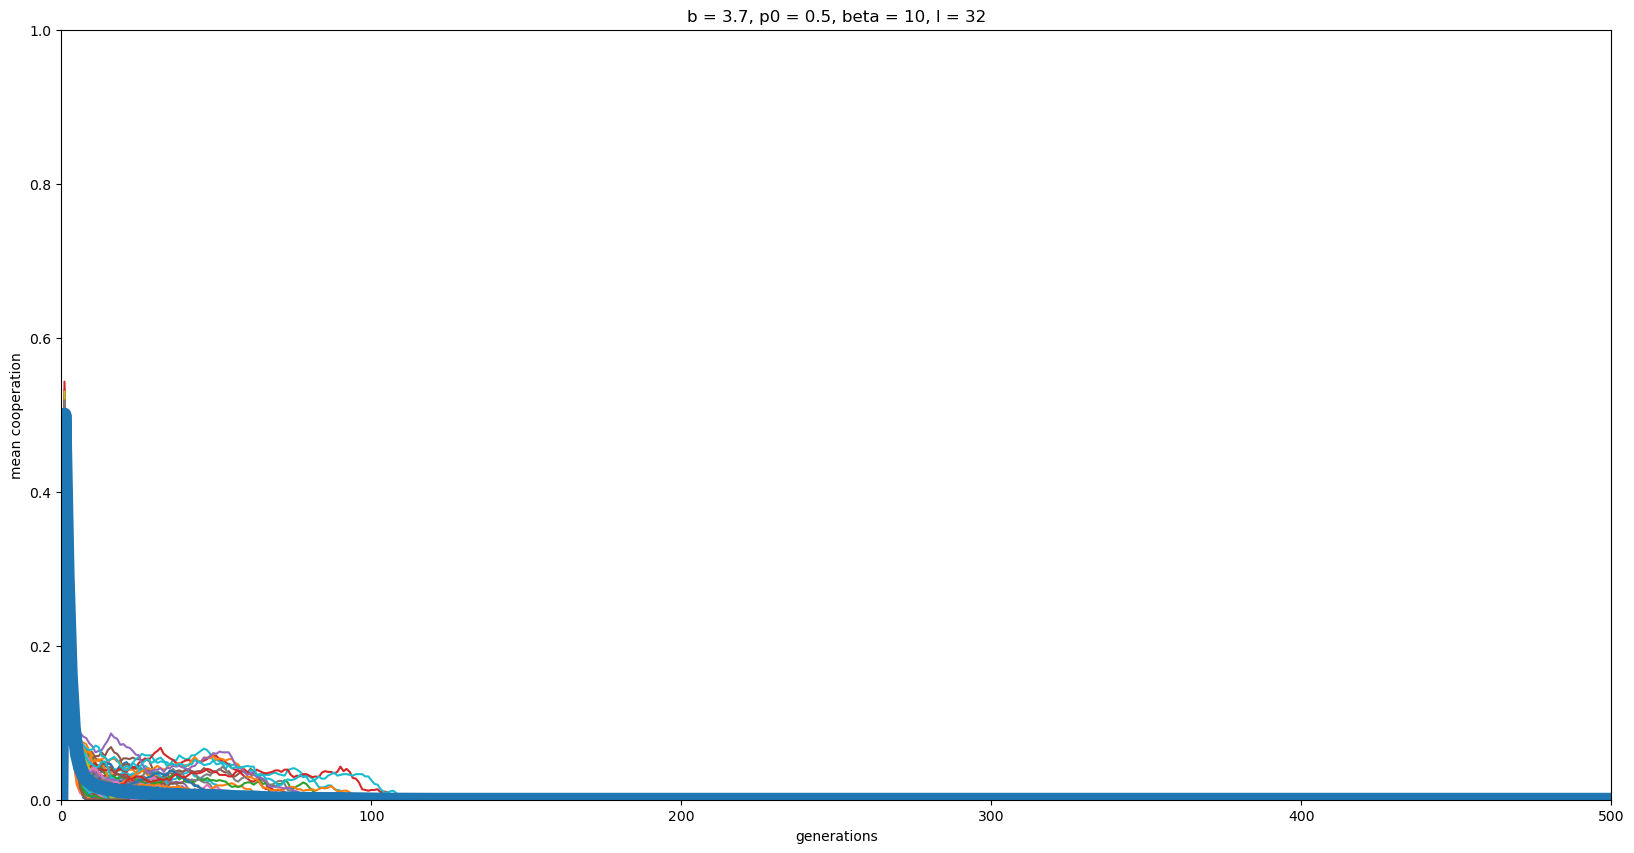

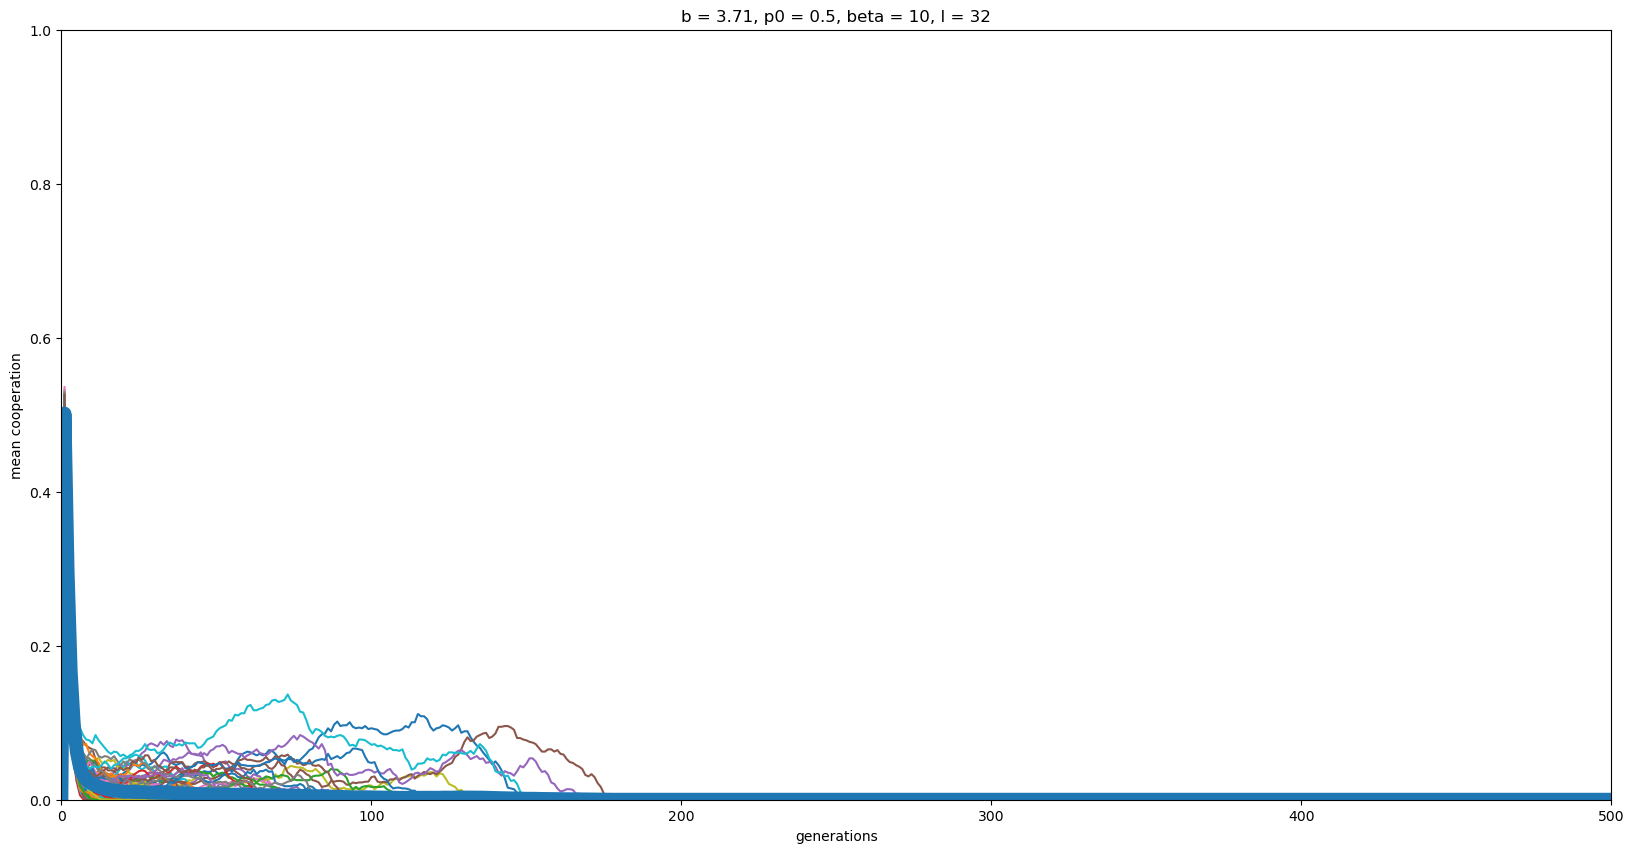

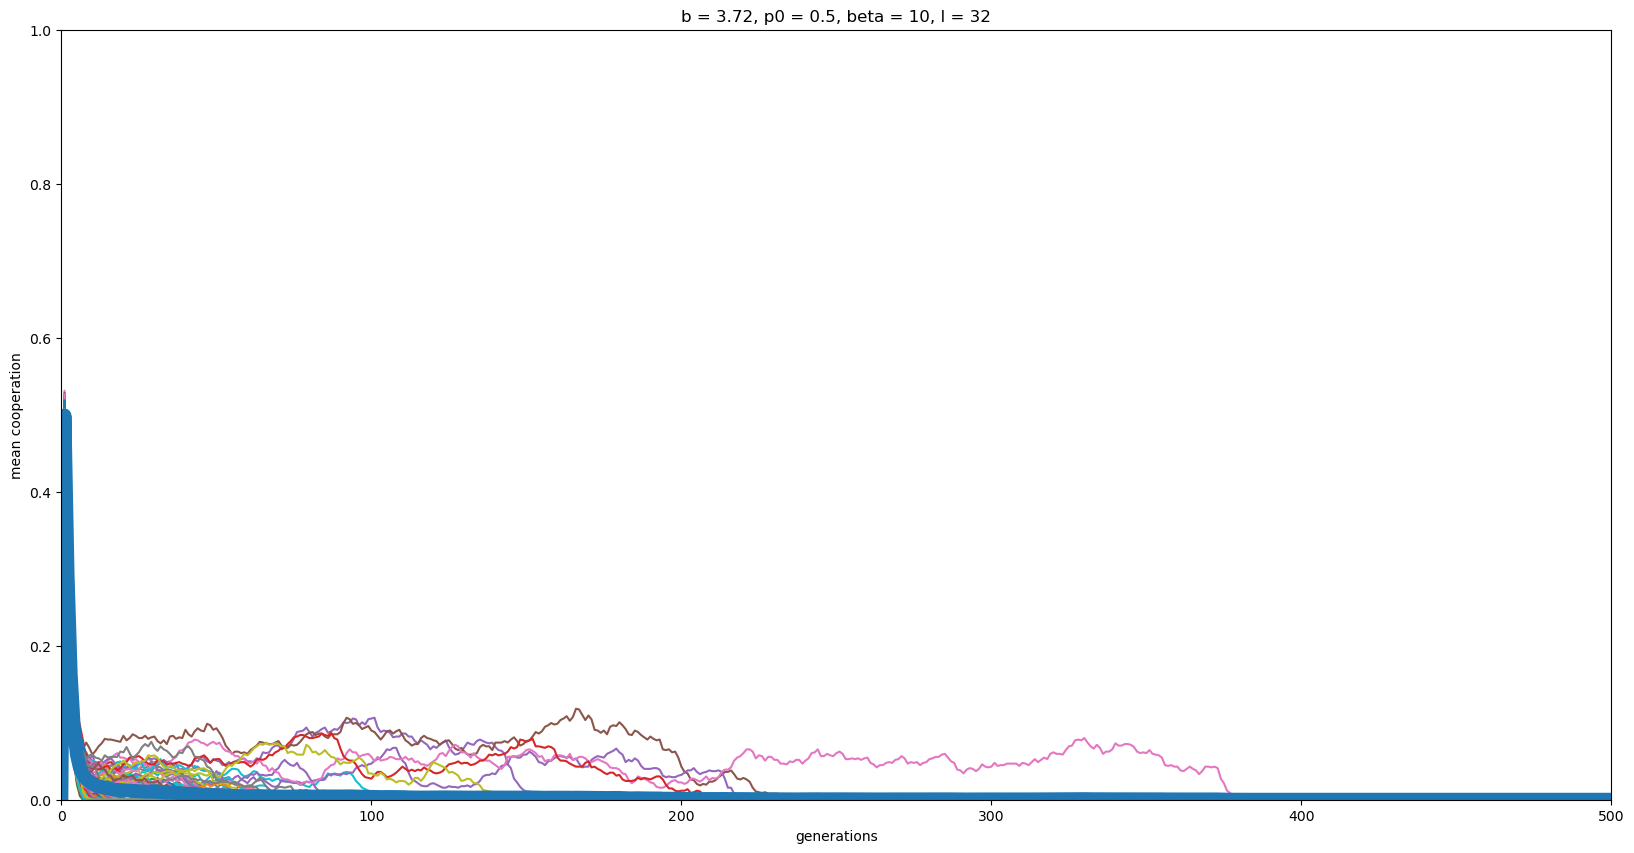

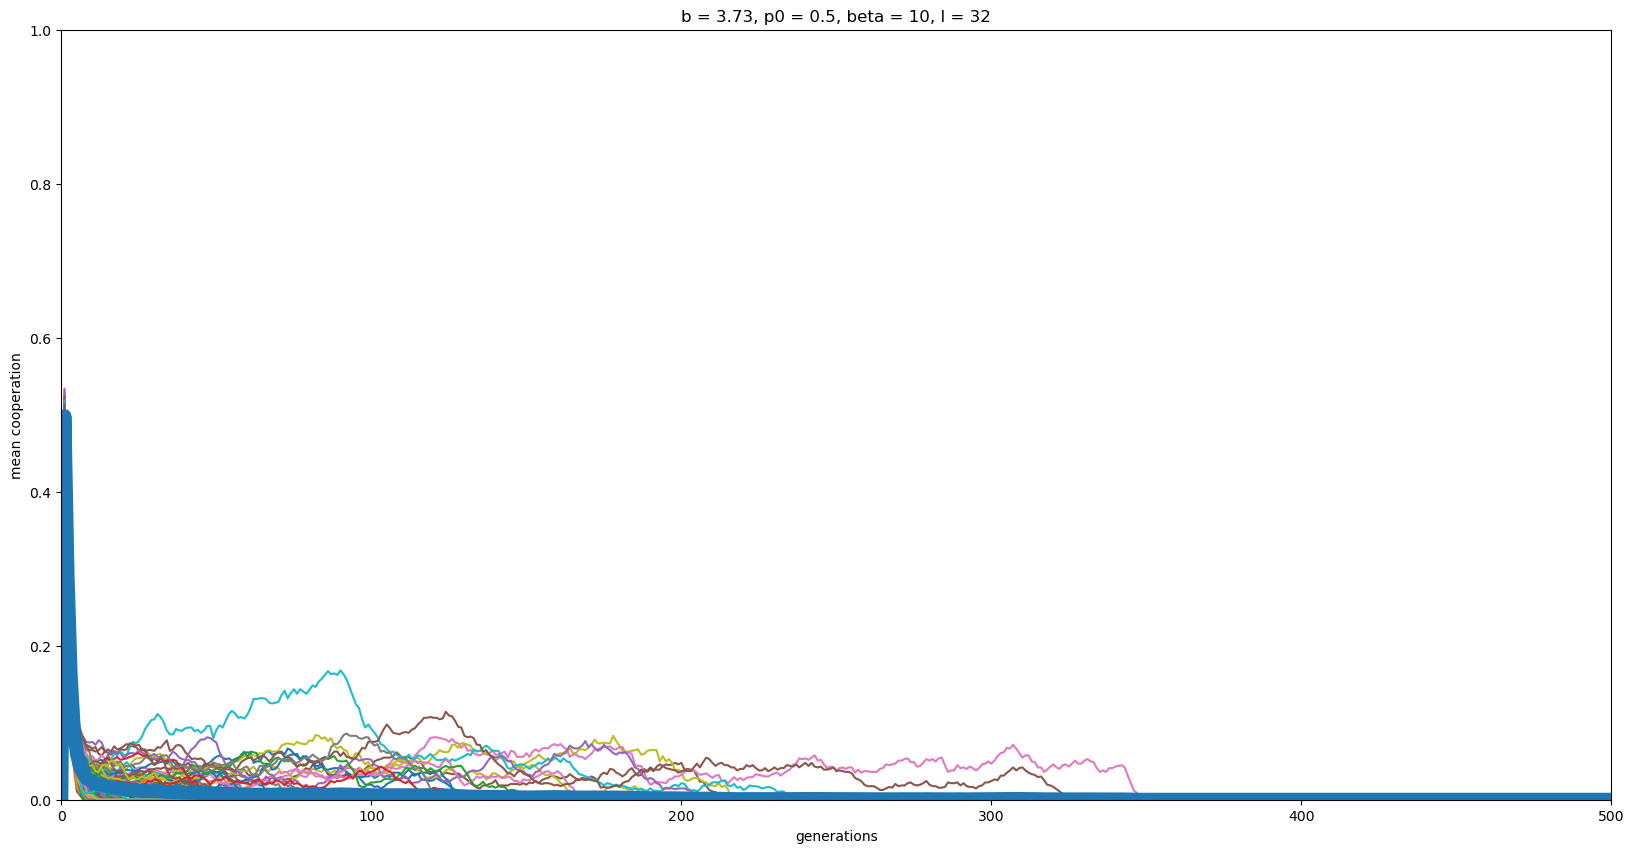

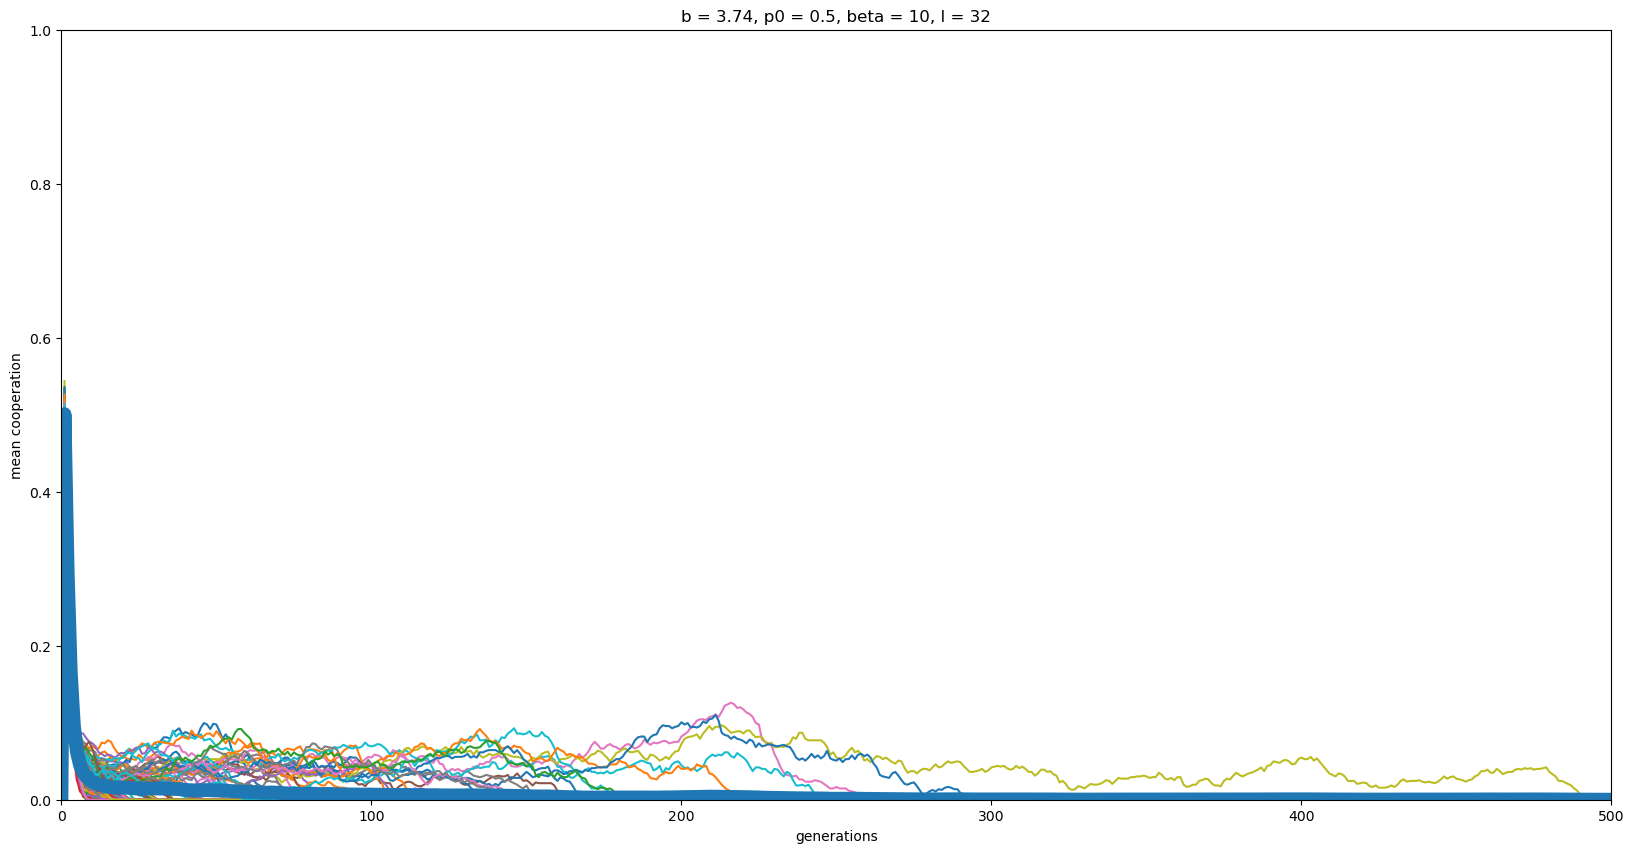

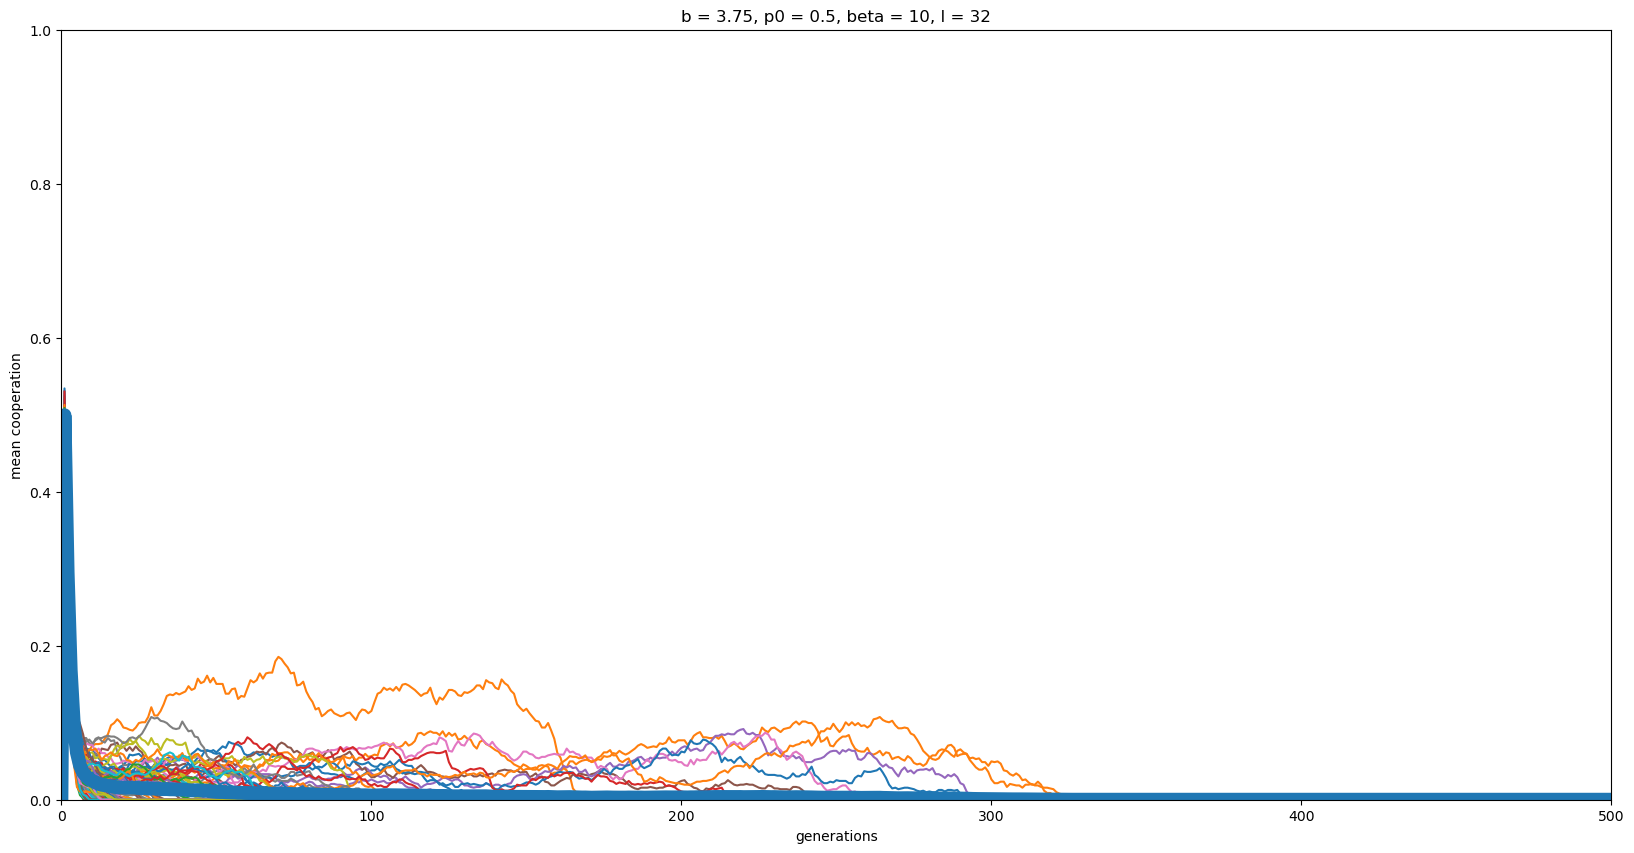

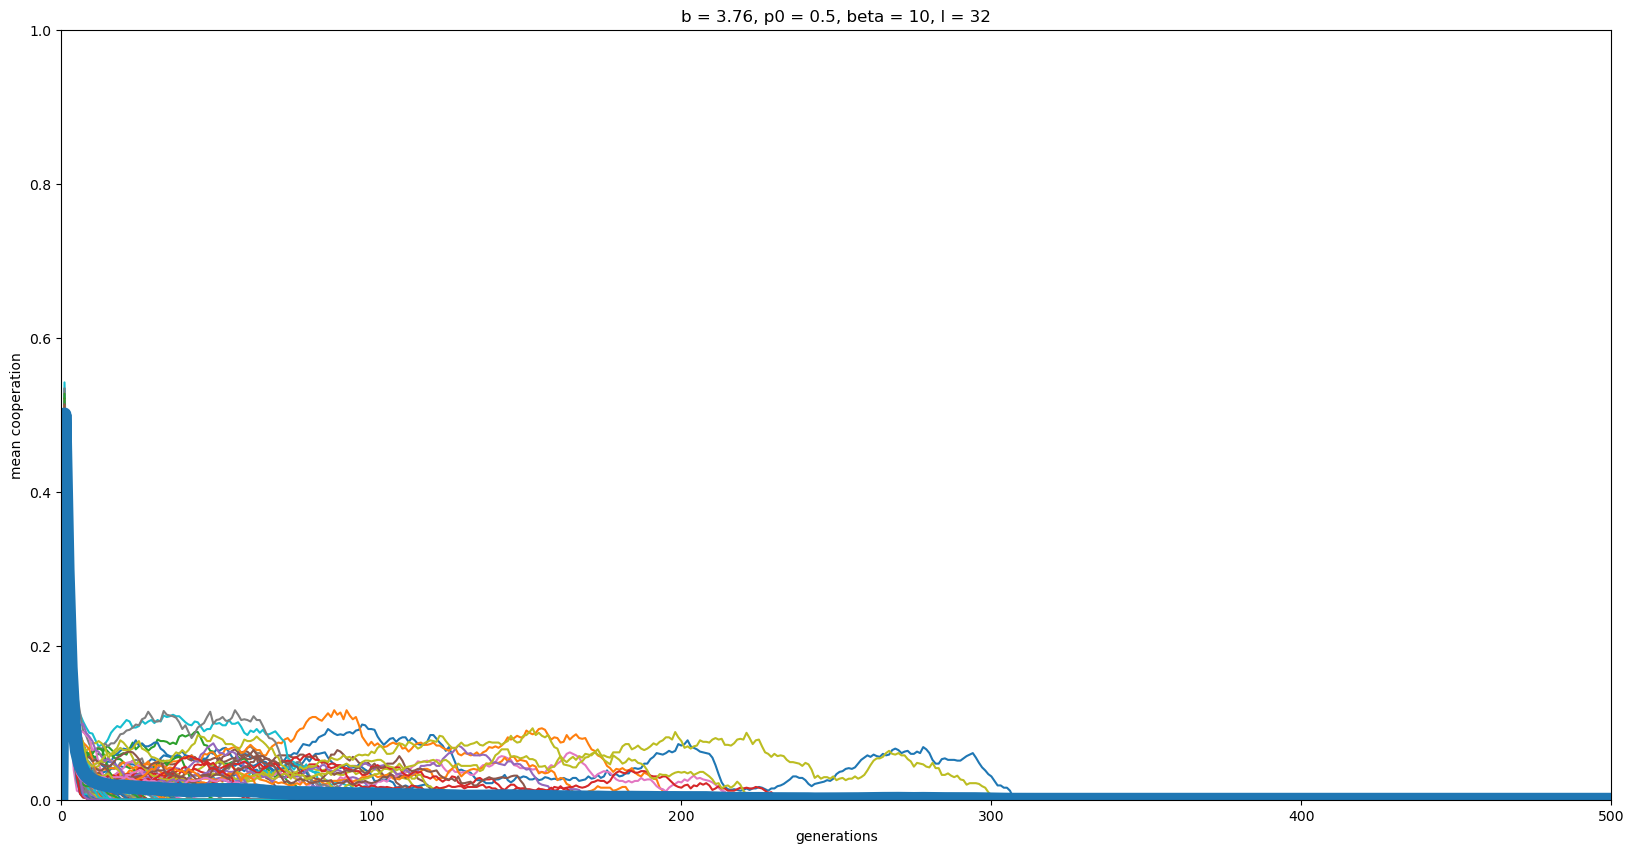

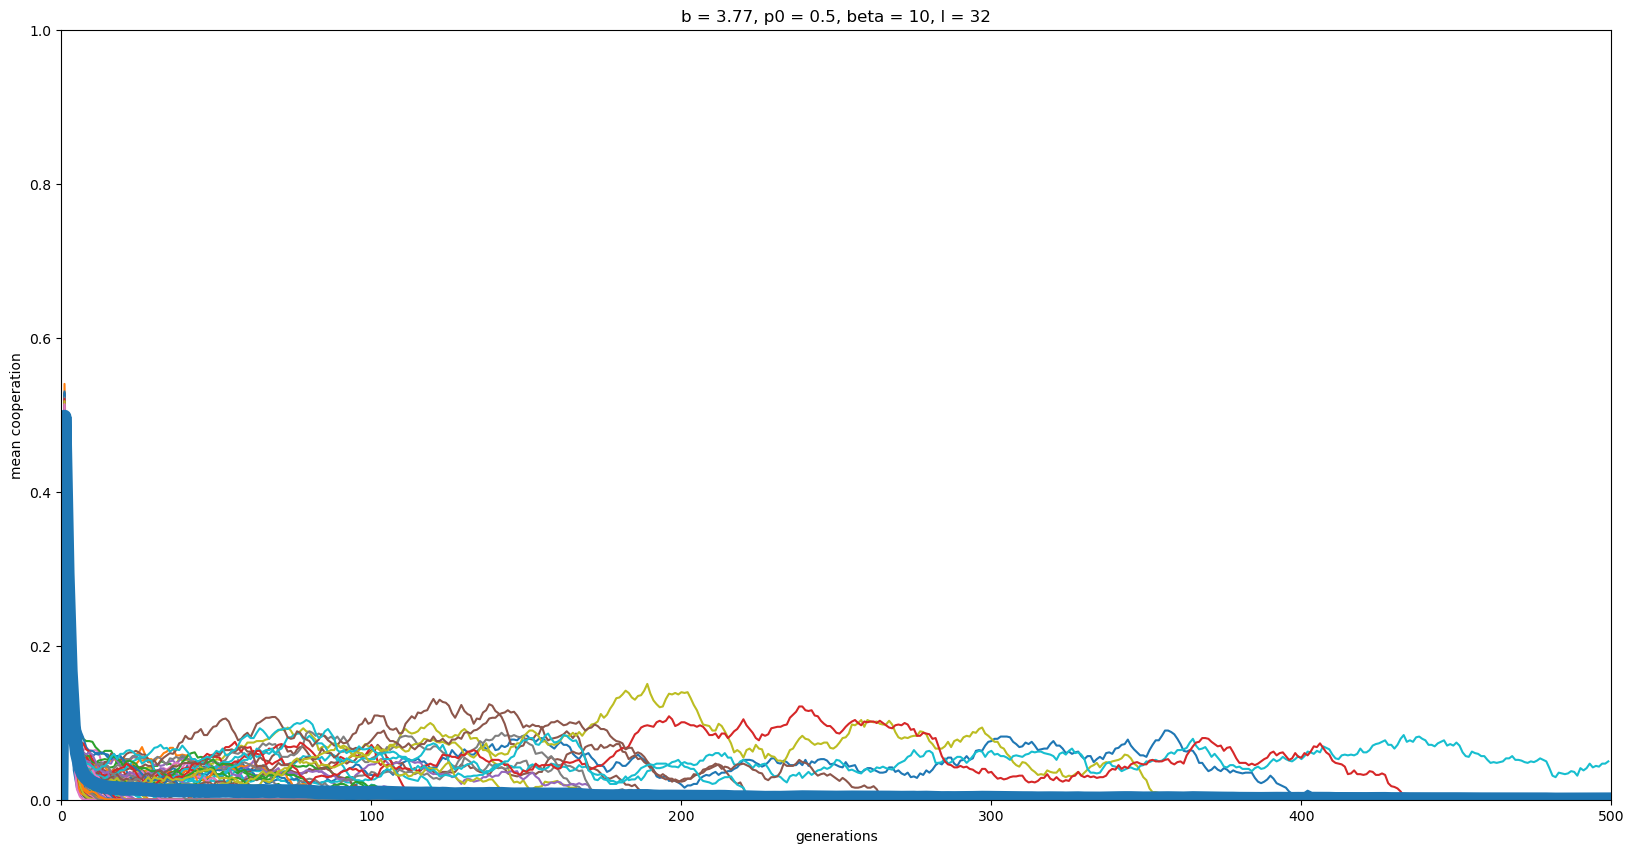

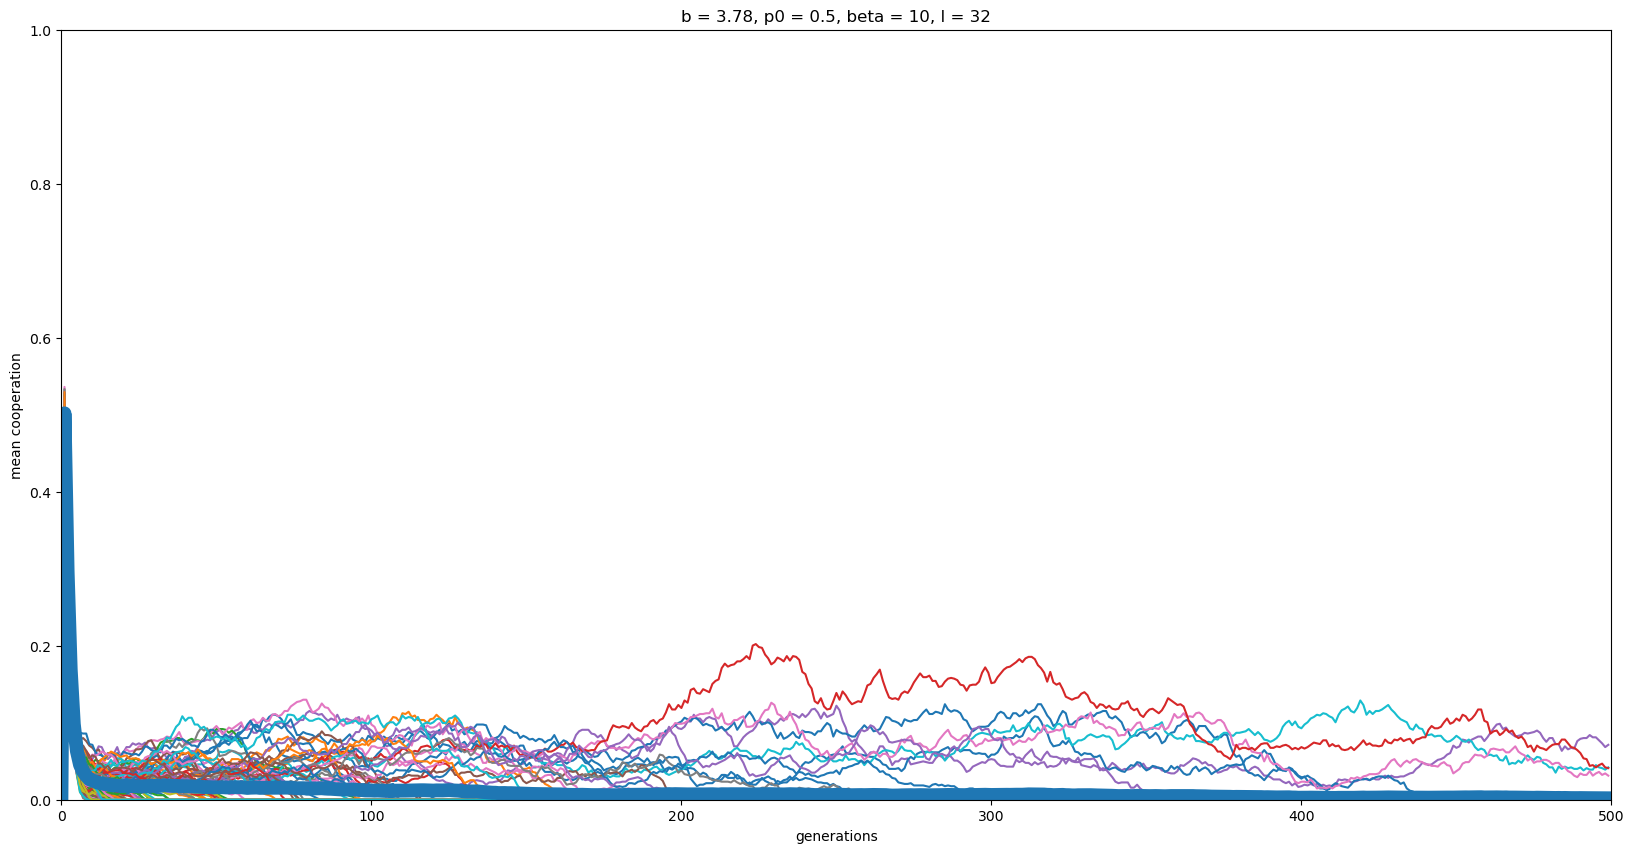

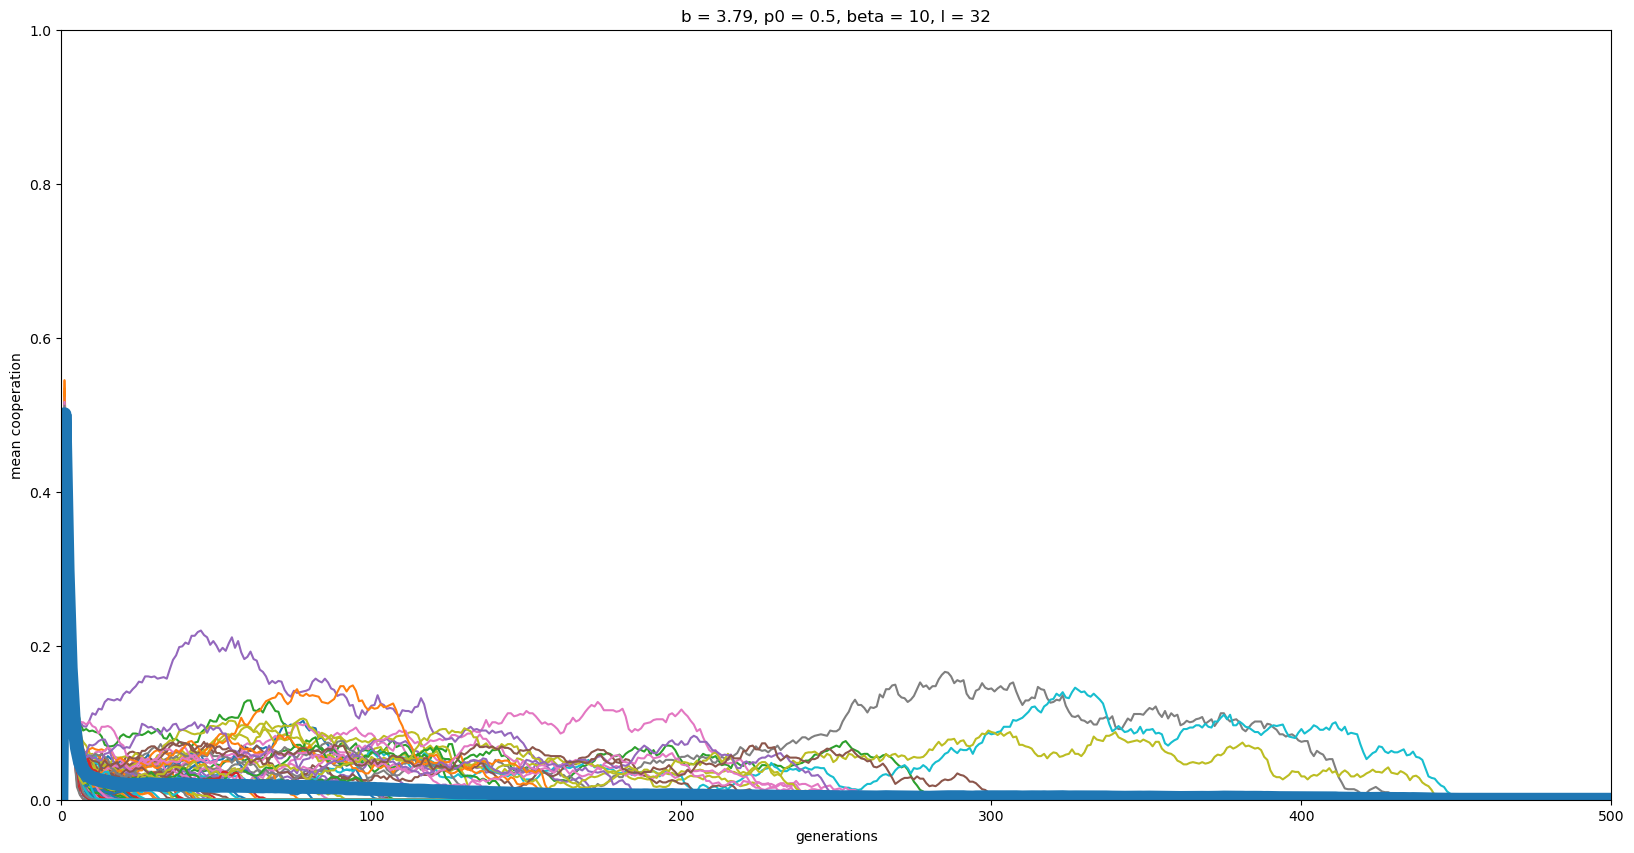

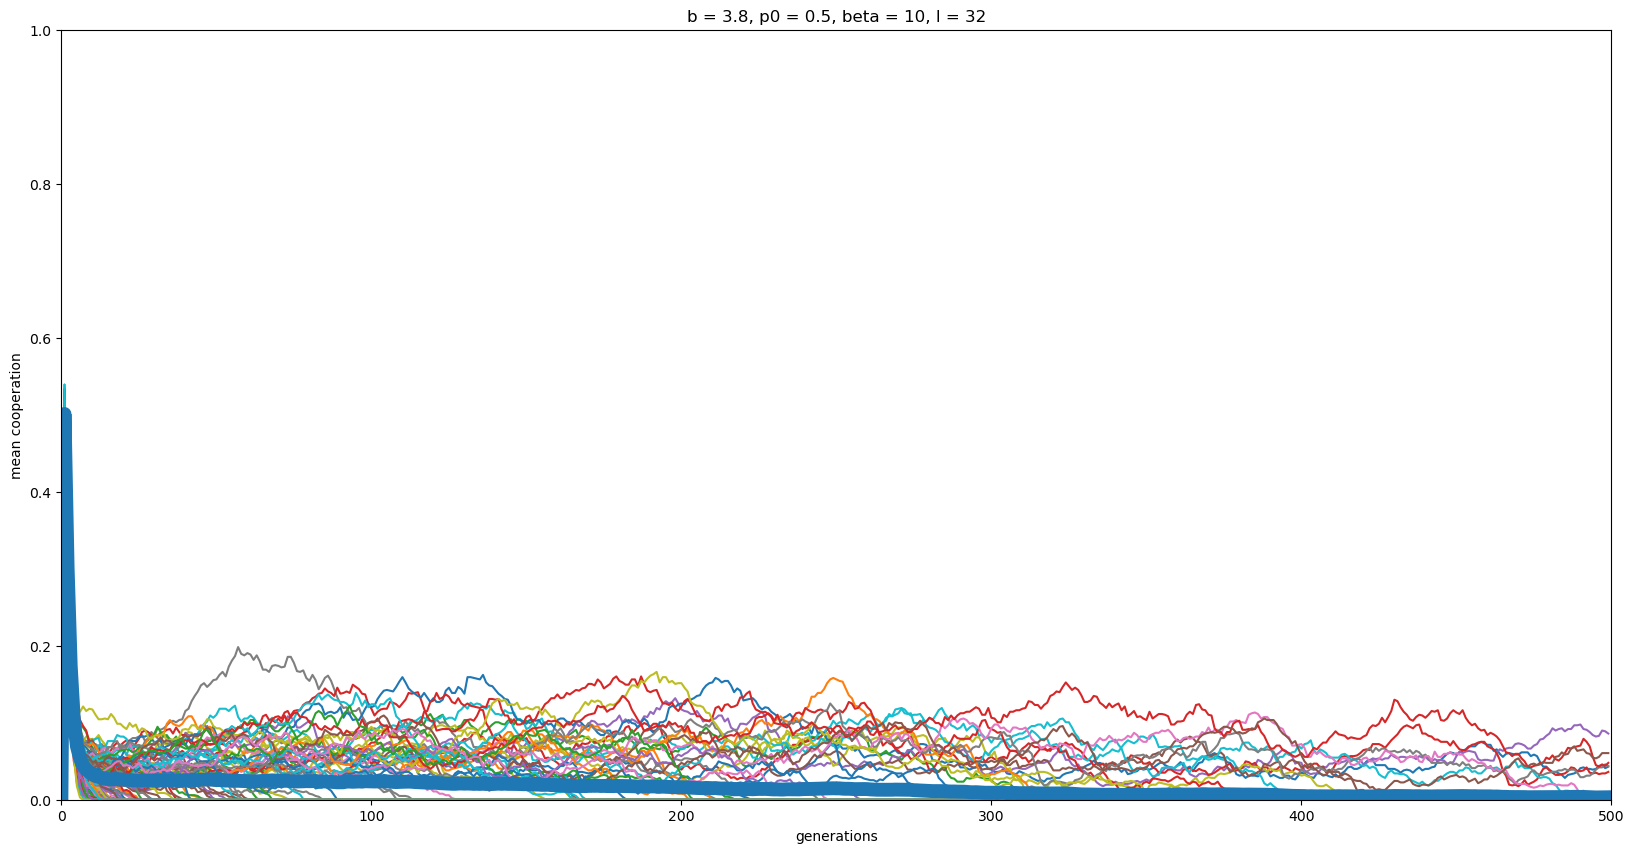

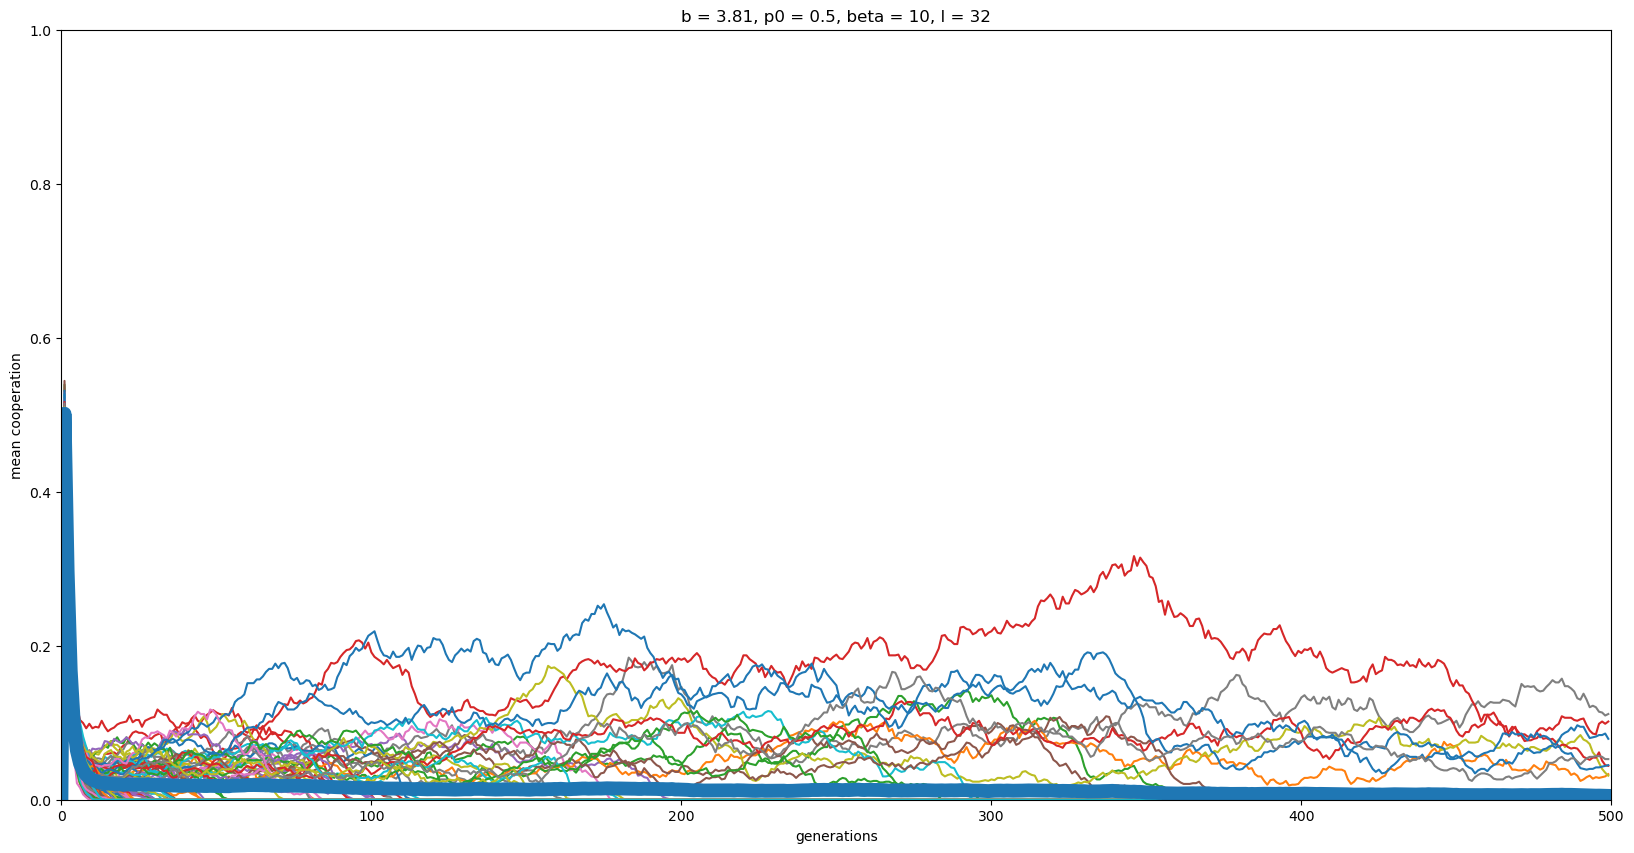

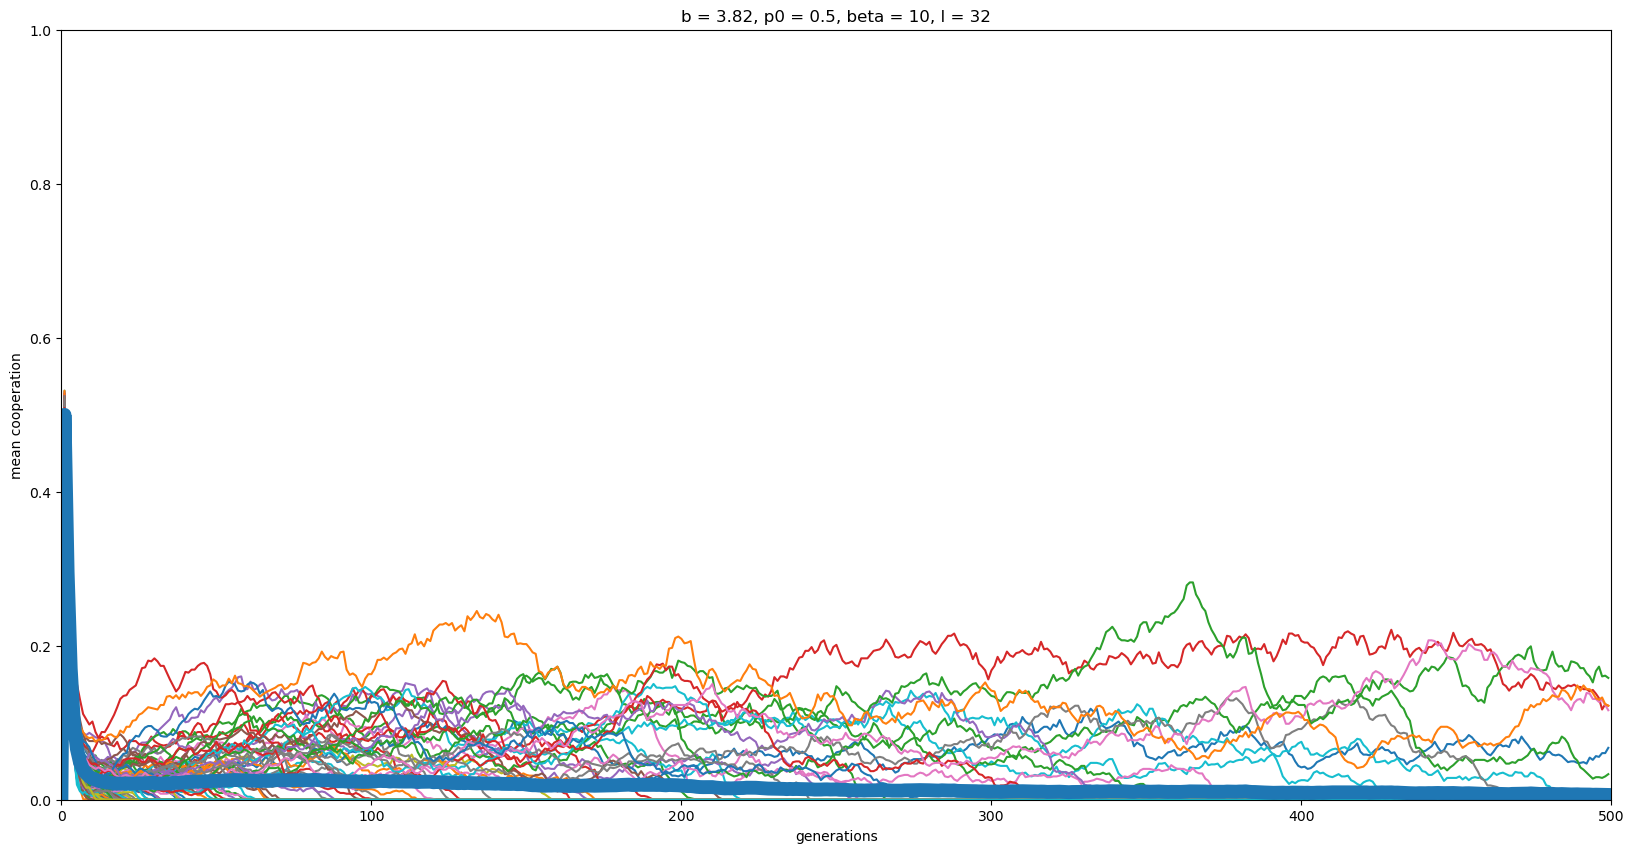

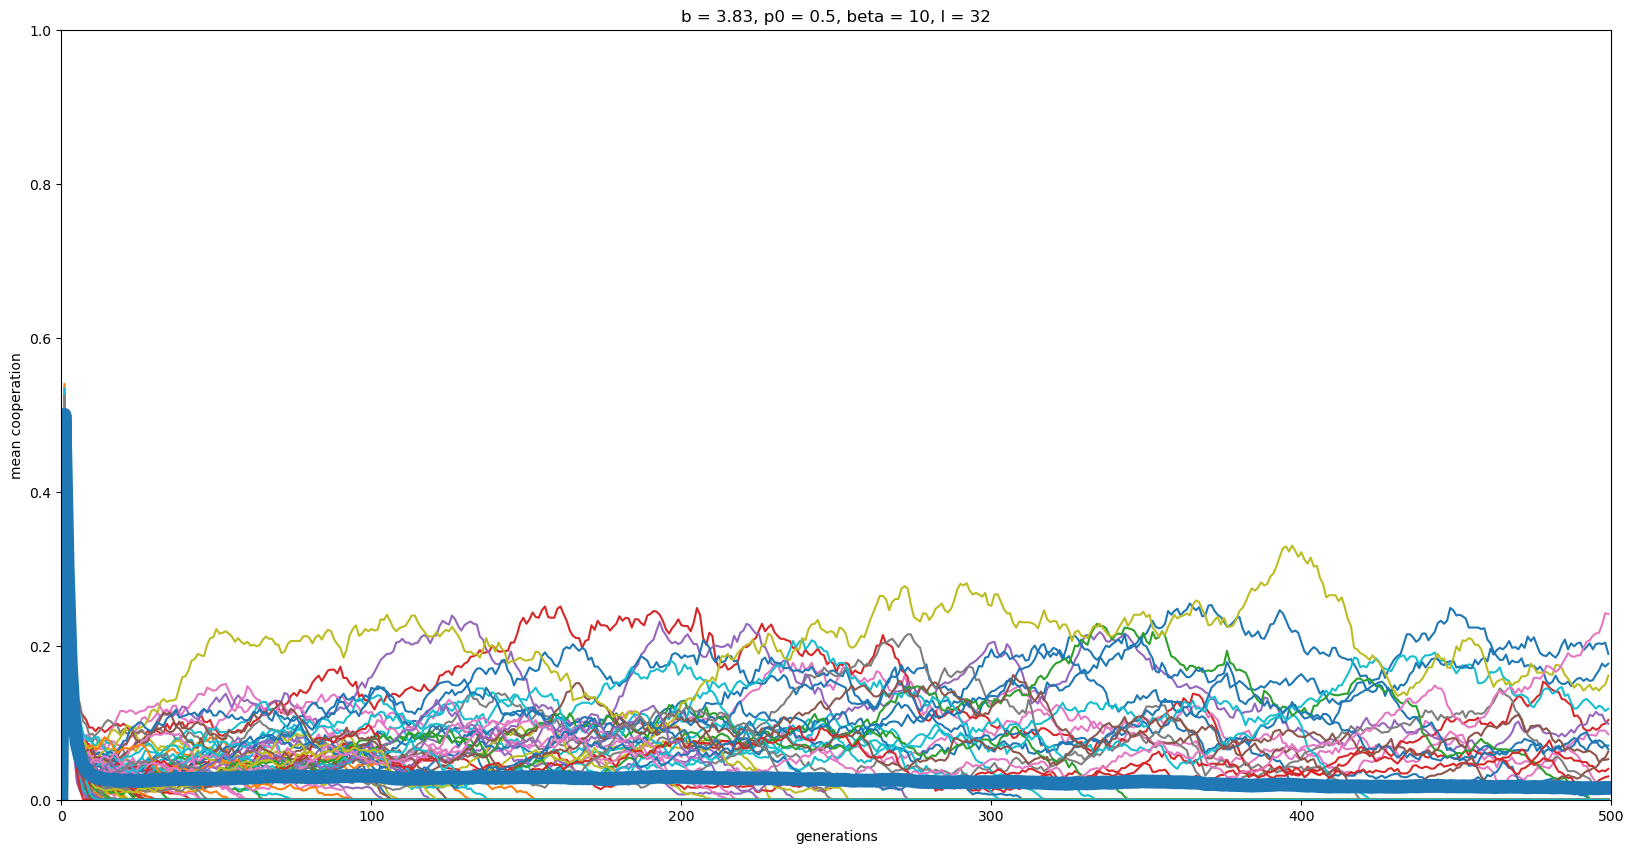

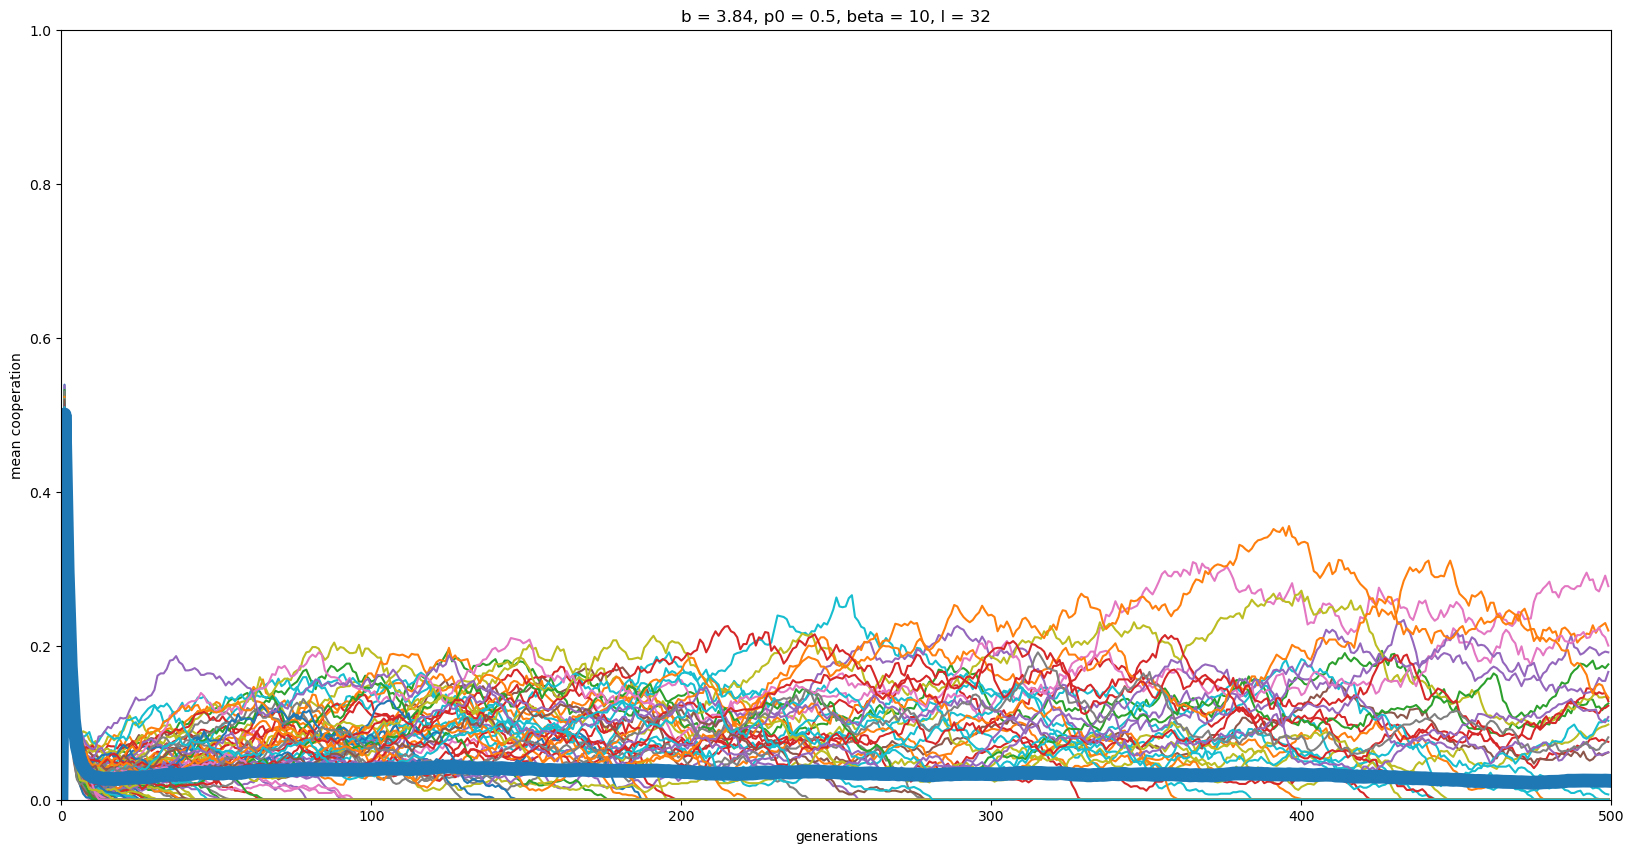

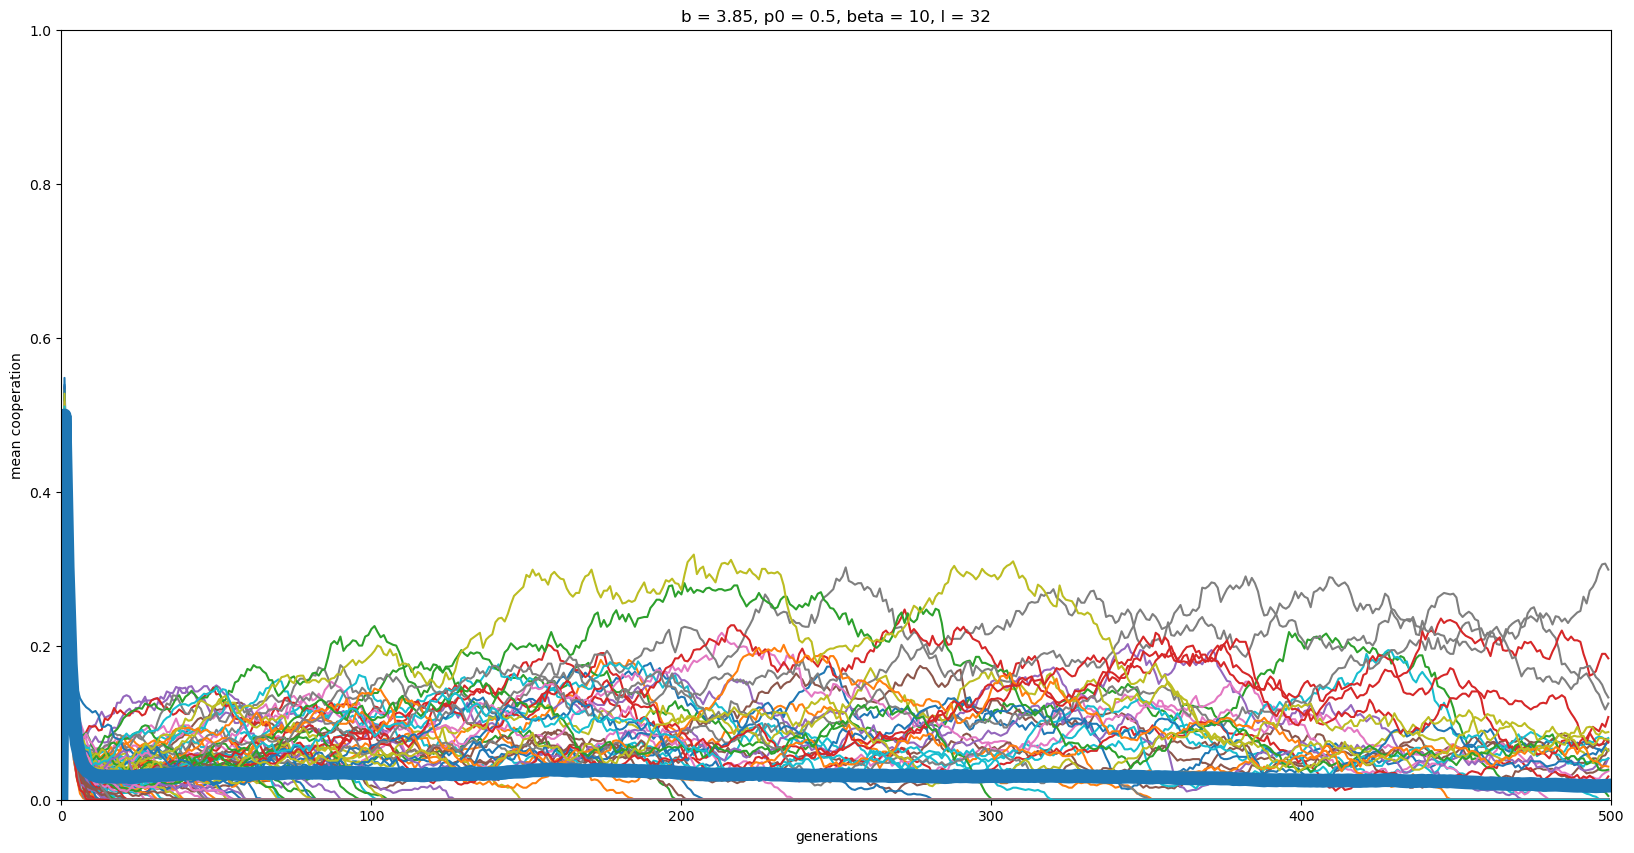

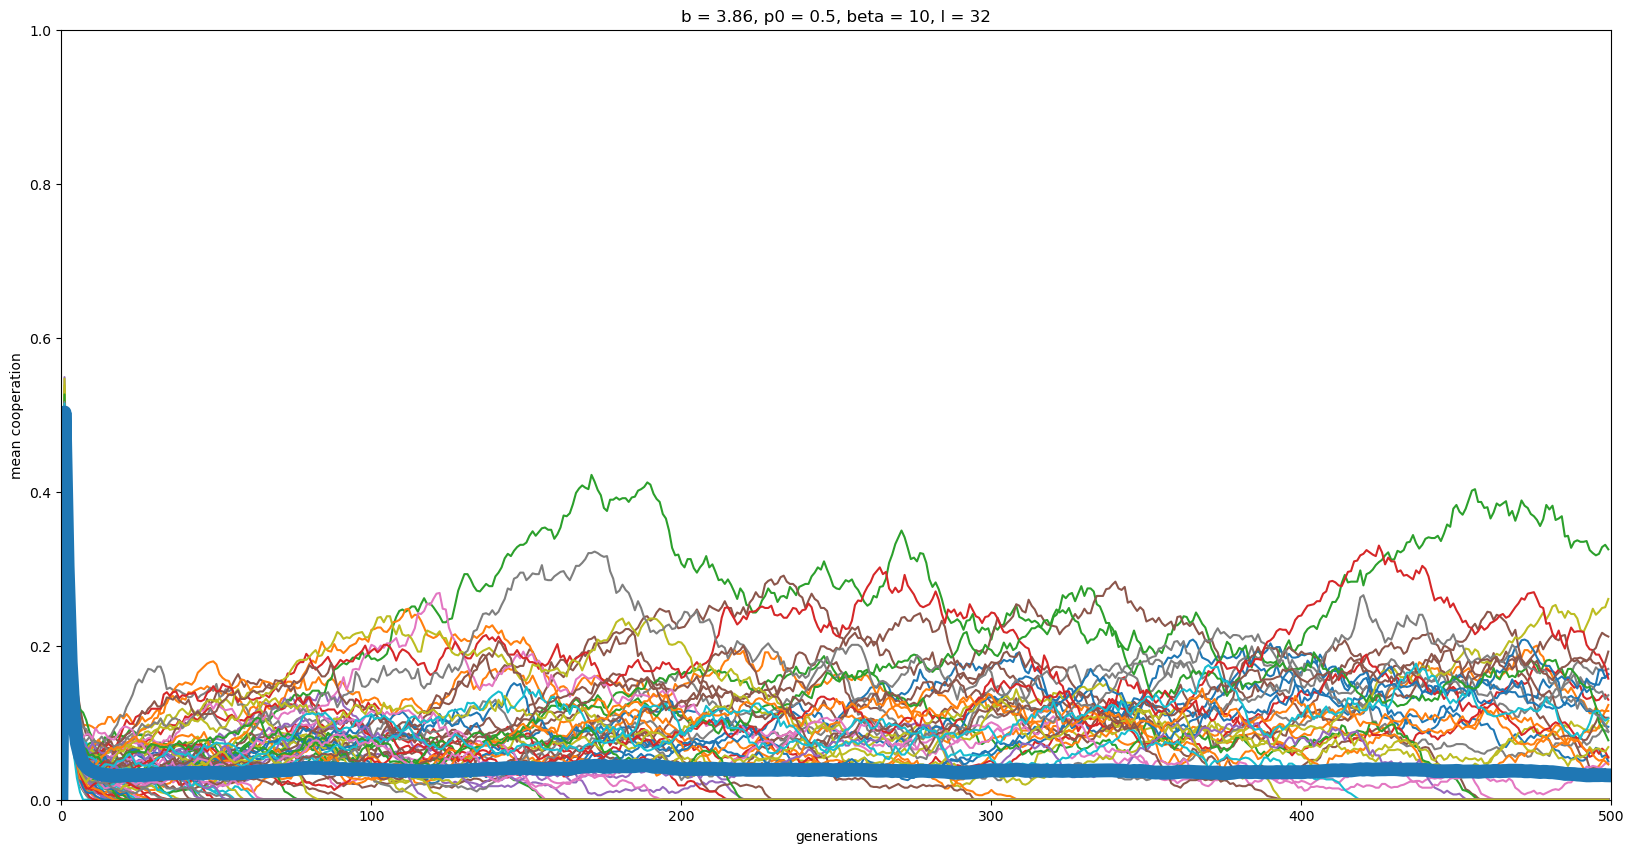

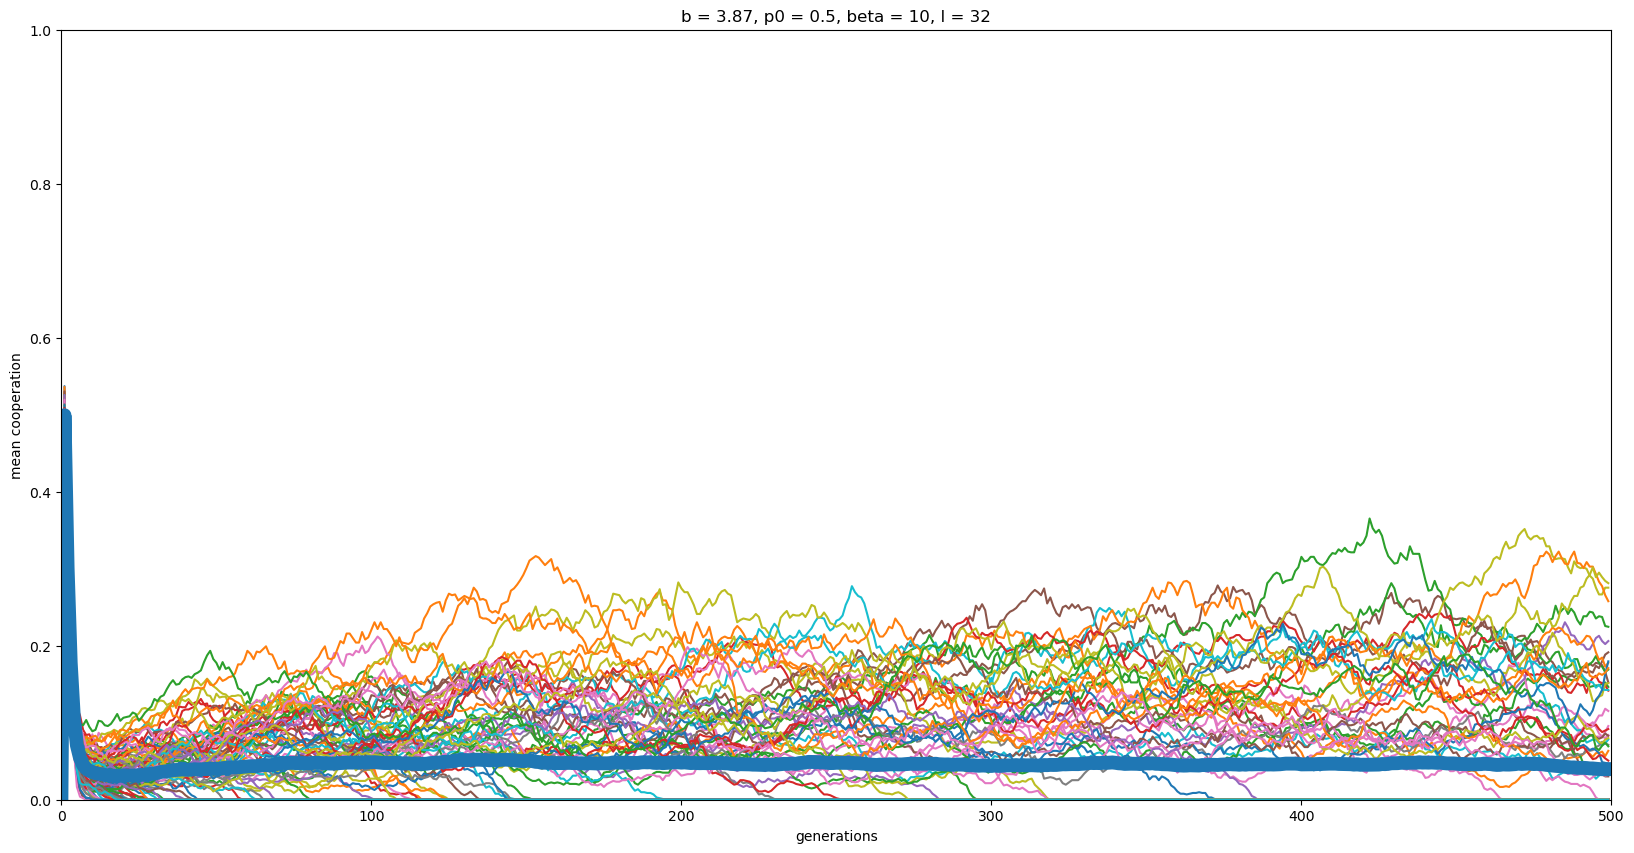

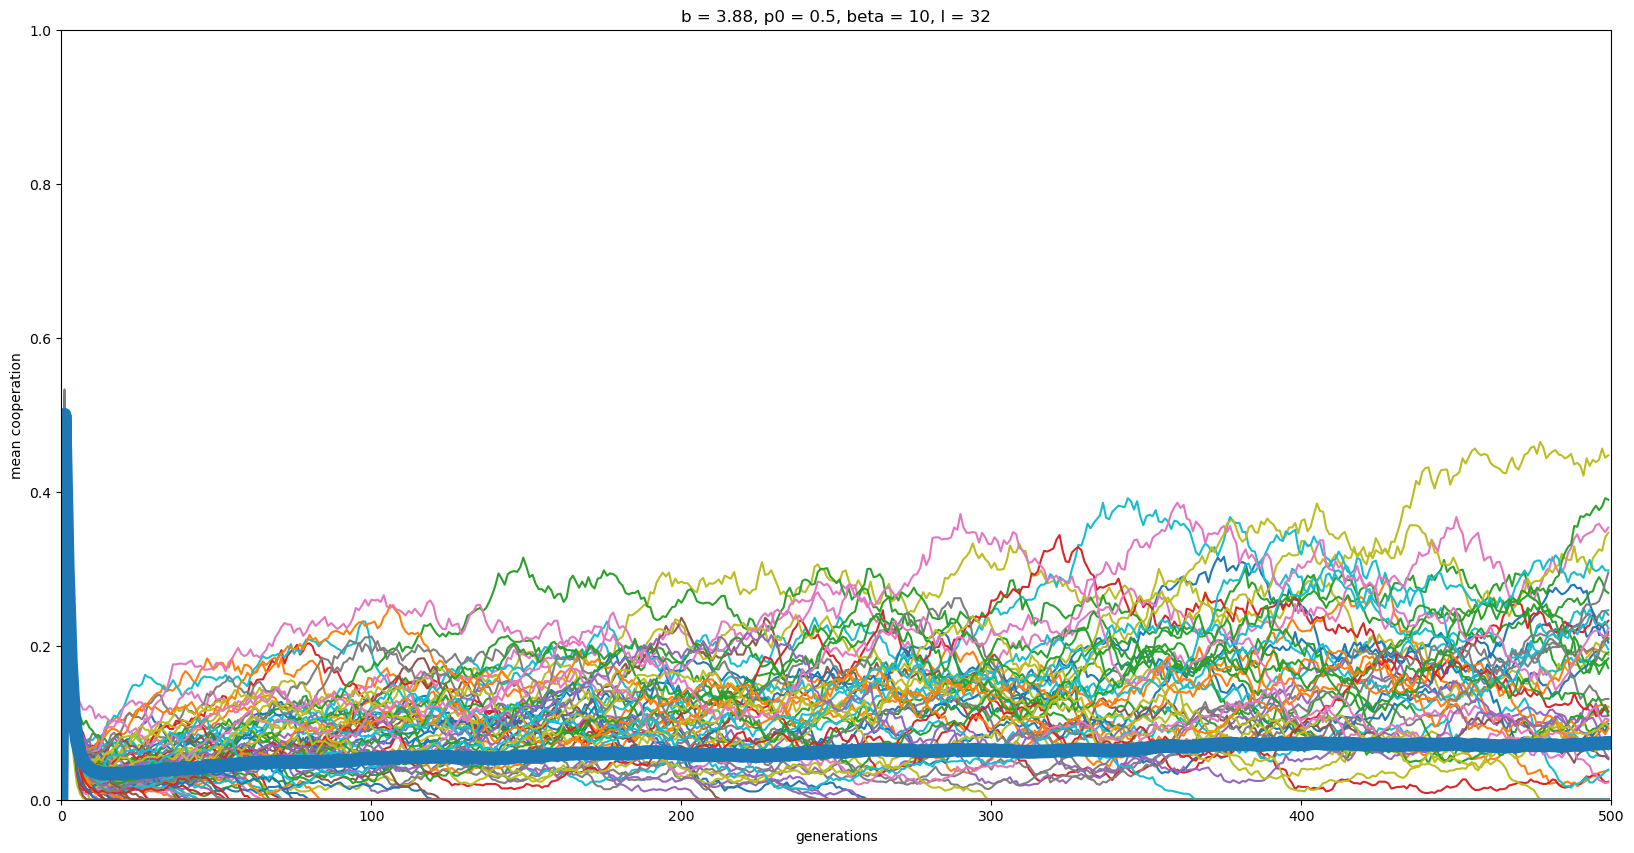

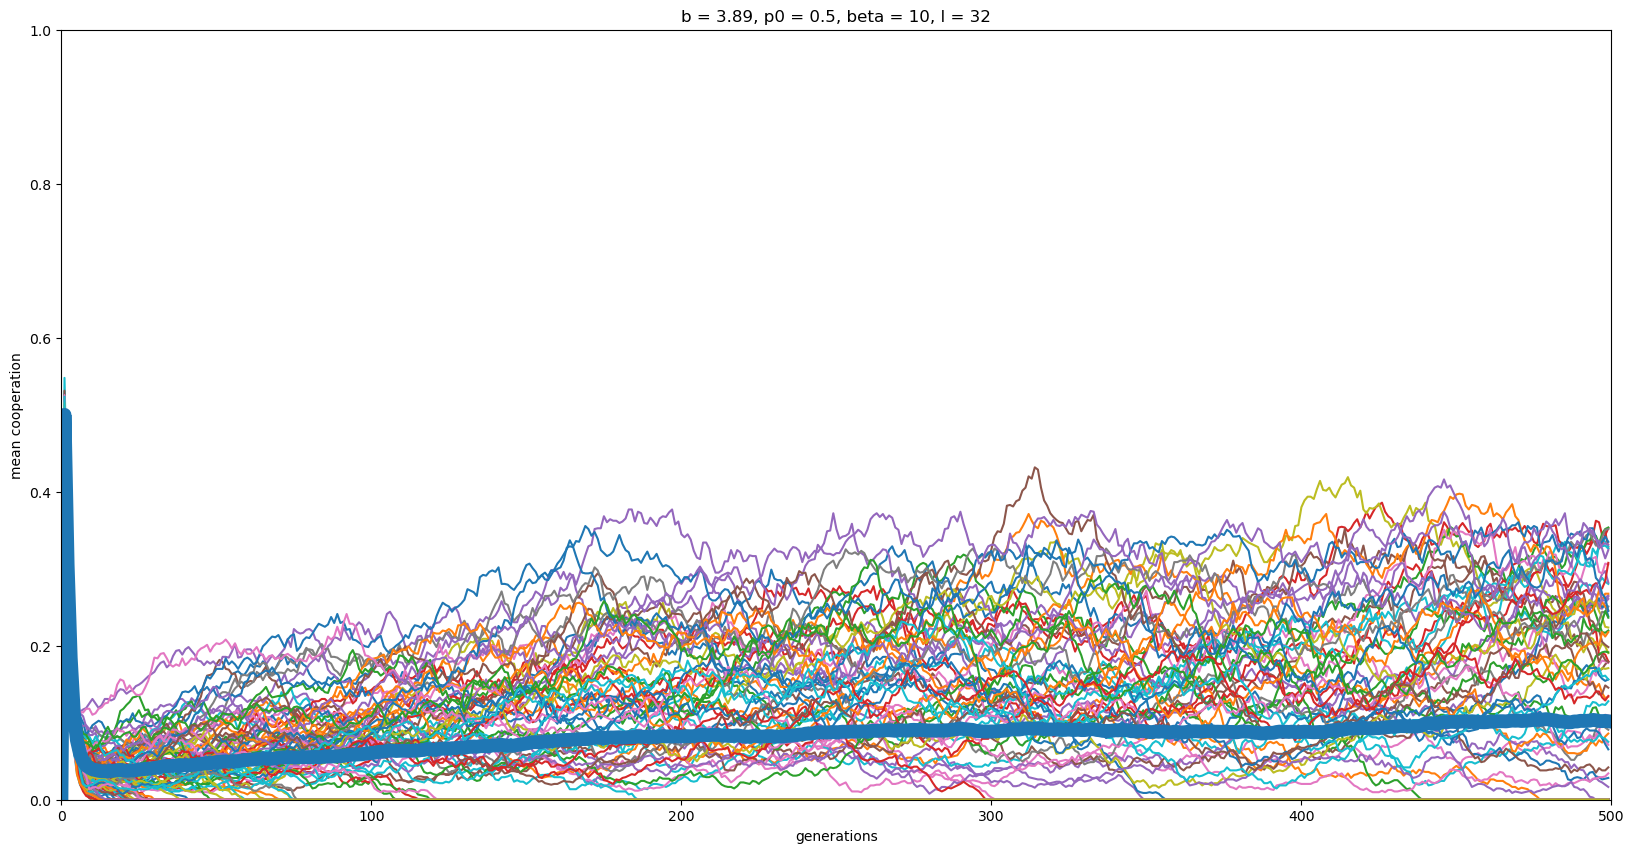

In [33]:
p0 = 0.50
beta = 10
bs = np.arange(370,390)/100
for b in bs:
    getResults2(p0,b,beta)



array([3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2,
       4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ])

In [15]:
p0 = 0.50
b = 3
m = 1
beta = 10


l = 32
N = l**2
generationsNum = 500
strategies = np.zeros((l,l))
strategies = np.ones((l,l))*(np.random.uniform(0,1,size=(l,l))<p0)

memory = np.ones((l,l,1,2),dtype=np.float64) 
record = np.zeros((l,l,generationsNum,2),dtype=np.float64)
indexMatrix = getIndexMatrix(l)
iterations = 100
datas = np.zeros((iterations,generationsNum))

for i in range(iterations):
    strategies = np.ones((l,l))*(np.random.random(size=(l,l))<p0)
    memory = np.zeros((l,l,1,2),dtype=np.float64) 
    record = np.zeros((l,l,generationsNum,2),dtype=np.float64)
    for t in range(1,generationsNum):

        
        strategies,record,memory = stepLogic(strategies,record,memory,m,t)
        
    data = np.sum(record[:,:,:,0],axis=(0,1))/(l*l)
    datas[i,:] = data
    

mean = np.mean(datas,axis=0)      


plt.figure(figsize=(20,10))
plt.title('b = '+str(b)+', p0 = '+str(p0)+', beta = '+str(beta)+', m = '+str(m)+ ", l = "+str(l))
plt.xlabel('generations')
plt.ylabel('mean cooperation')
plt.xlim((0,generationsNum))
plt.ylim((0,1))
for i in range(iterations):
    plt.plot(np.arange(generationsNum),datas[i,:])
    



plt.plot(np.arange(generationsNum),mean,lw= 10)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
NameError: name 'l' is not defined

In [72]:
datas[:,-1]

array([0.01660156, 0.02734375, 0.02050781, 0.02929688, 0.02734375,
       0.0234375 , 0.046875  , 0.01269531, 0.015625  , 0.0234375 ,
       0.01171875, 0.01171875, 0.01953125, 0.01464844, 0.02929688,
       0.0390625 , 0.01269531, 0.0390625 , 0.01269531, 0.0234375 ,
       0.02539062, 0.015625  , 0.02636719, 0.02734375, 0.02929688,
       0.03027344, 0.00585938, 0.03417969, 0.02832031, 0.01953125,
       0.02636719, 0.02539062, 0.02832031, 0.02050781, 0.01660156,
       0.04589844, 0.0390625 , 0.02832031, 0.04199219, 0.02148438,
       0.02050781, 0.05664062, 0.02636719, 0.01269531, 0.01269531,
       0.05273438, 0.02636719, 0.02441406, 0.02148438, 0.03320312])

In [314]:
memory.dtype

dtype('float64')

In [315]:
benefits = getBenefits(strategies,b)
memory = updateMemory(strategies,benefits,memory,3)
alternativeStrategies = 1- strategies


In [316]:
memory.shape

(10, 10, 3, 2)

In [327]:
getAlternativesLogic(strategies,memory)

(array([[0., 0., 1., 1., 0., 1., 0., 1., 1., 0.],
        [1., 1., 0., 1., 1., 1., 0., 0., 1., 0.],
        [1., 0., 0., 1., 0., 1., 0., 1., 1., 0.],
        [0., 0., 1., 1., 1., 1., 1., 0., 1., 1.],
        [0., 1., 1., 1., 1., 0., 1., 0., 1., 0.],
        [0., 1., 1., 0., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0., 1., 0., 0., 1., 1.],
        [0., 0., 1., 1., 1., 0., 1., 0., 0., 1.],
        [1., 1., 1., 0., 0., 1., 0., 0., 0., 1.]]),
 array([[1.56, 1.2 , 1.38, 1.2 , 1.08, 1.56, 1.5 , 1.84, 1.62, 1.5 ],
        [1.44, 1.52, 1.2 , 1.32, 1.14, 1.44, 1.32, 1.36, 1.56, 1.44],
        [1.72, 1.5 , 0.9 , 1.2 , 0.75, 1.26, 1.08, 1.52, 1.44, 1.32],
        [1.44, 1.14, 1.5 , 0.  , 0.96, 1.32, 1.44, 1.2 , 1.32, 1.76],
        [1.32, 1.62, 0.  , 1.2 , 1.32, 1.16, 1.72, 1.44, 1.84, 1.4 ],
        [1.38, 1.92, 1.2 , 1.  , 1.6 , 1.68, 1.56, 1.68, 1.36, 1.92],
        [0.  , 1.12, 1.62, 0.96, 1.68, 1.5 , 2.04, 1.62, 1.8 , 1.36],
        

In [318]:
getAlternativesLogic(strategies,memory)

(array([[0., 0., 1., 1., 0., 1., 0., 1., 1., 0.],
        [1., 1., 0., 1., 1., 1., 0., 0., 1., 0.],
        [1., 0., 0., 1., 0., 1., 0., 1., 1., 0.],
        [0., 0., 1., 1., 1., 1., 1., 0., 1., 1.],
        [0., 1., 1., 1., 1., 0., 1., 0., 1., 0.],
        [0., 1., 1., 0., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0., 1., 0., 0., 1., 1.],
        [0., 0., 1., 1., 1., 0., 1., 0., 0., 1.],
        [1., 1., 1., 0., 0., 1., 0., 0., 0., 1.]]),
 array([[1.56, 1.2 , 1.38, 1.2 , 1.08, 1.56, 1.5 , 1.84, 1.62, 1.5 ],
        [1.44, 1.52, 1.2 , 1.32, 1.14, 1.44, 1.32, 1.36, 1.56, 1.44],
        [1.72, 1.5 , 0.9 , 1.2 , 0.75, 1.26, 1.08, 1.52, 1.44, 1.32],
        [1.44, 1.14, 1.5 , 0.  , 0.96, 1.32, 1.44, 1.2 , 1.32, 1.76],
        [1.32, 1.62, 0.  , 1.2 , 1.32, 1.16, 1.72, 1.44, 1.84, 1.4 ],
        [1.38, 1.92, 1.2 , 1.  , 1.6 , 1.68, 1.56, 1.68, 1.36, 1.92],
        [0.  , 1.12, 1.62, 0.96, 1.68, 1.5 , 2.04, 1.62, 1.8 , 1.36],
        

In [99]:
#kernel = np.array([[0,1,0],[1,1,1],[0,1,0]],dtype=np.float64)
# threadsperblock = (4,4)
# blockspergrid_x = math.ceil(N/threadsperblock[0])
# blockspergrid_y = math.ceil(N/threadsperblock[1])
# blockspergrid = (blockspergrid_x, blockspergrid_y)
#     
# groupValues = np.zeros(strategies.shape,dtype=np.float64)
#applyKernel(strategies,kernel,np.zeros(strategies.shape))
